In [359]:
# based on example: https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html

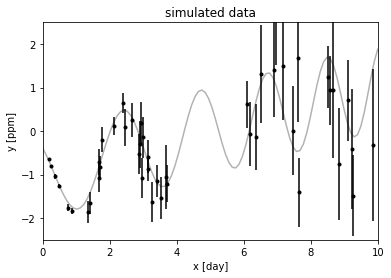

In [360]:
import numpy as np
import matplotlib.pyplot as plt

random = np.random.default_rng(42)

t = np.sort(
    np.append(
        random.uniform(0, 3.8, 28),
        random.uniform(5.5, 10, 18),
    )
)
# yerr = random.uniform(0.08, 0.22, len(t)) * t**2/10
yerr = random.uniform(0.08, 0.22, len(t)) * t
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [361]:
import jax.scipy

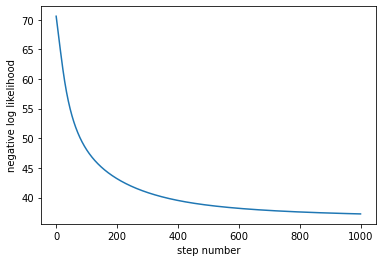

In [362]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        
        diag = yerr**2 + jnp.exp(log_jitter)
        # diag = jnp.exp(log_jitter)
        
        gp = GaussianProcess(
            kernel, x, diag=diag, mean=mean
        )

        # log_prob, gp_cond = gp.condition(y, t, diag=jnp.exp(log_jitter))
        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc, gp_cond.variance


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

In [363]:
np.mean(yerr**2)

0.5781684375335433

In [364]:
np.exp(params['params']['log_jitter'])

0.0016344069

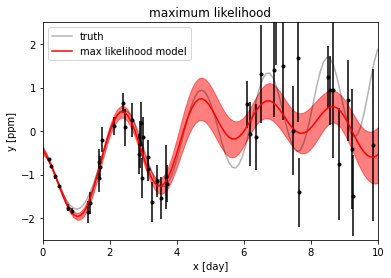

In [365]:
pred_mu = model.apply(params, t, yerr, y, true_t)[1]
pred_var = model.apply(params, t, yerr, y, true_t)[2]
pred_std = np.sqrt(pred_var)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred_mu, label="max likelihood model", c='r')
plt.fill_between(true_t, y1=pred_mu-pred_std, y2=pred_mu+pred_std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

# heteroskedasticity: modelling log_jitter with a polynomial

In [366]:
t.shape

(46,)

In [367]:
y.shape

(46,)

In [368]:
yerr.shape

(46,)

In [369]:
true_t.shape

(100,)

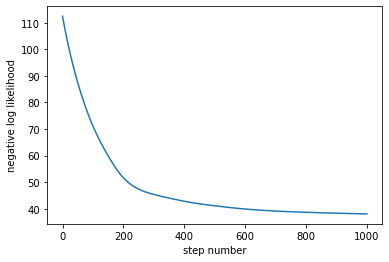

In [370]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax

polynomial_noise_model = lambda a, b, c, x: a + b*x + c*x**2


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        # log_jitter = self.param("log_jitter", zeros, ())
        log_jitter_a = self.param("log_jitter_a", zeros, ())
        log_jitter_b = self.param("log_jitter_b", zeros, ())
        log_jitter_c = self.param("log_jitter_c", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        
        # diag = yerr**2 + jnp.exp(log_jitter)
        # diag = jnp.exp(log_jitter_c) * x**2 + jnp.exp(log_jitter_a) * x + jnp.exp(log_jitter_b)
        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), x)
        
        gp = GaussianProcess(
            kernel, x, diag=diag, mean=mean
        )

        # diag = jnp.exp(log_jitter_c) * t**2 + jnp.exp(log_jitter_a) * t + jnp.exp(log_jitter_b)
        diag = polynomial_noise_model(jnp.exp(log_jitter_a), jnp.exp(log_jitter_b), jnp.exp(log_jitter_c), t)
        log_prob, gp_cond = gp.condition(y, t, diag=diag)
        return -log_prob, gp_cond.loc, gp_cond.variance


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

In [371]:
params['params']

FrozenDict({
    log_jitter_a: Array(-5.6176066, dtype=float32),
    log_jitter_b: Array(-5.087844, dtype=float32),
    log_jitter_c: Array(-4.3021336, dtype=float32),
    log_rho1: Array(0.8668926, dtype=float32),
    log_rho2: Array(0.95653915, dtype=float32),
    log_sigma1: Array(-0.6036863, dtype=float32),
    log_sigma2: Array(-0.34529385, dtype=float32),
    log_tau: Array(1.4864914, dtype=float32),
    mean: Array(-0.361921, dtype=float32),
})

In [372]:
np.exp(params['params']['log_jitter_a'])

0.0036333266

In [373]:
np.exp(params['params']['log_jitter_b'])

0.0061713117

In [374]:
# diag_ = np.exp(params['params']['log_jitter_c']) * true_t**2 + np.exp(params['params']['log_jitter_a']) * true_t + np.exp(params['params']['log_jitter_b'])
diag_ = polynomial_noise_model(jnp.exp(params['params']['log_jitter_a']), jnp.exp(params['params']['log_jitter_b']), jnp.exp(params['params']['log_jitter_c']), true_t)

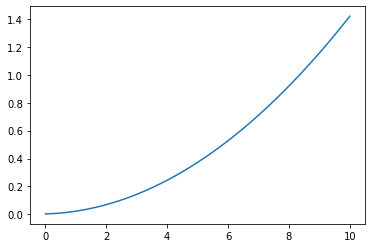

In [375]:
plt.plot(true_t, diag_)

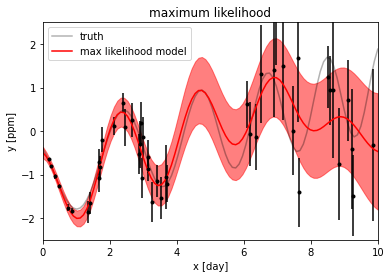

In [376]:
pred_mu = model.apply(params, t, yerr, y, true_t)[1]
pred_var = model.apply(params, t, yerr, y, true_t)[2]
pred_std = np.sqrt(pred_var)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred_mu, label="max likelihood model", c='r')
plt.fill_between(true_t, y1=pred_mu-pred_std, y2=pred_mu+pred_std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

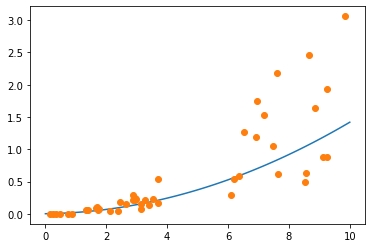

In [377]:
plt.plot(true_t, diag_)
plt.plot(t, yerr**2, 'o')

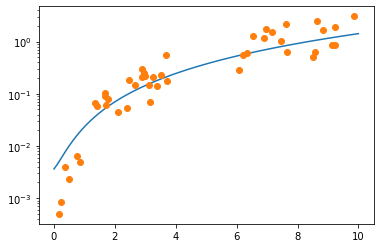

In [378]:
plt.plot(true_t, diag_)
plt.plot(t, yerr**2, 'o')
plt.yscale('log')

# heteroskedasticity: modelling log_jitter with a gp??

In [379]:
gp2_kernel2 = kernels.ExpSquared(1.5)
gp2 = GaussianProcess(gp2_kernel2, t)

In [380]:
gp2_sample = gp2.sample(jax.random.PRNGKey(4), shape=(10,))


In [381]:
gp2_sample.shape

(10, 46)

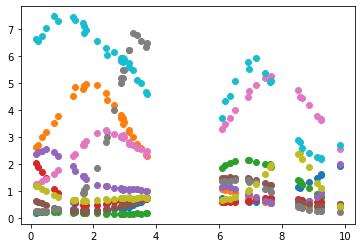

In [382]:
plt.plot(t, np.exp(gp2_sample.T), 'o')

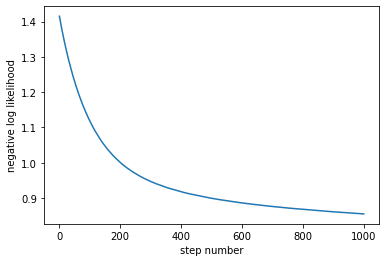

In [383]:
from tinygp import kernels, GaussianProcess

import jax
import jax.numpy as jnp

import flax.linen as nn
from flax.linen.initializers import zeros

import optax


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern32(jnp.exp(log_rho2))

        kernel = kernel1 + kernel2
        
        # diag = yerr**2 + jnp.exp(log_jitter)
        diag = jnp.exp(log_jitter)
        gp2_log_sigma = self.param("gp2_log_sigma", zeros, ())
        gp2_log_rho = self.param("gp2_log_rho", zeros, ())
        # gp2_kernel2 = jnp.exp(2 * gp2_log_sigma) * kernels.ExpSquared(jnp.exp(gp2_log_rho))
        gp2_kernel2 = jnp.exp(2 * gp2_log_sigma) * kernels.Matern32(jnp.exp(gp2_log_rho))
        # gp2 = GaussianProcess(gp2_kernel2, x, mean=jnp.exp(log_jitter))
        gp2 = GaussianProcess(gp2_kernel2, x)
        # gp2_sample_diag = jnp.exp(gp2.sample(jax.random.PRNGKey(4), shape=(1,))[0])
        # _, gp2_cond = gp2.condition(yerr**2, x)
        # gp2_sample_diag = jnp.exp(gp2_cond.loc)
        gp2_sample_diag = jnp.exp(gp2.loc)
        
        gp = GaussianProcess(
            kernel, x, diag=diag, mean=mean
        )

        # _, gp2_cond = gp2.condition(yerr**2, t)
        # _, gp2_cond = gp2.condition(t)
        # gp2_sample_diag = jnp.exp(gp2_cond.sample(jax.random.PRNGKey(4), shape=(1,))[0])
        # gp2_sample_diag = jnp.exp(gp2_cond.loc)
        gp2_sample_diag = jnp.exp(gp2.predict(y, x))

        # log_prob, gp_cond = gp.condition(y, t, diag=gp2_sample_diag)
        log_prob, gp_cond = gp.condition(y, x)

        log_prob_new = jax.scipy.stats.norm.logpdf(y, loc=gp_cond.loc, scale=gp2_sample_diag)

        # return -log_prob, gp_cond.loc, gp_cond.variance
        # return -log_prob_new.mean(), gp_cond.loc, gp_cond.variance
        
        
        
        # predictions
        _, gp_cond = gp.condition(y, t)
        gp2_sample_diag = jnp.exp(gp2.predict(y, t))
        
        
        return -log_prob_new.mean(), gp_cond.loc, gp_cond.variance, gp2_sample_diag


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]


model = GPModule()
params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
# tx = optax.adam(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(1001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

In [384]:
params['params']

FrozenDict({
    gp2_log_rho: Array(0.3324327, dtype=float32),
    gp2_log_sigma: Array(-0.22776775, dtype=float32),
    log_jitter: Array(-0.40964392, dtype=float32),
    log_rho1: Array(0.29176253, dtype=float32),
    log_rho2: Array(-0.31859666, dtype=float32),
    log_sigma1: Array(0.13843319, dtype=float32),
    log_sigma2: Array(0.6808549, dtype=float32),
    log_tau: Array(-0.12303898, dtype=float32),
    mean: Array(-0.13936037, dtype=float32),
})

In [385]:
np.exp(params['params']['gp2_log_rho'])

1.394356

In [386]:
np.exp(params['params']['gp2_log_sigma'])

0.7963092

In [387]:
pred_mu.shape

(100,)

In [388]:
t.shape

(46,)

In [389]:
y.shape

(46,)

In [390]:
# pred_mu = model.apply(params, t, yerr, y, true_t)[1]
# pred_var = model.apply(params, t, yerr, y, true_t)[2]
# # pred_std = np.sqrt(pred_var)
# pred_std = pred_var

# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
# plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(t, pred_mu, label="max likelihood model", c='r')
# plt.fill_between(t, y1=pred_mu-pred_std, y2=pred_mu+pred_std, color='r', alpha=0.5)
# plt.xlabel("x [day]")
# plt.ylabel("y [ppm]")
# plt.xlim(0, 10)
# plt.ylim(-2.5, 2.5)
# plt.legend()
# _ = plt.title("maximum likelihood")

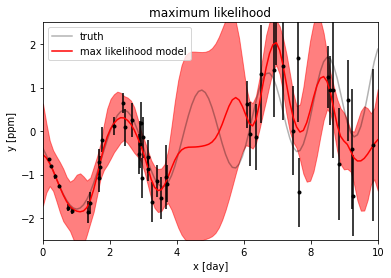

In [391]:
pred_mu = model.apply(params, t, yerr, y, true_t)[1]
pred_var = model.apply(params, t, yerr, y, true_t)[2]
gp2_diag = model.apply(params, t, yerr, y, true_t)[3]
pred_std = np.sqrt(pred_var)
# pred_std = gp2_diag
# pred_std = pred_var
# pred_std = pred_var**2

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(true_t, pred_mu, label="max likelihood model", c='r')
plt.fill_between(true_t, y1=pred_mu-pred_std, y2=pred_mu+pred_std, color='r', alpha=0.5)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.legend()
_ = plt.title("maximum likelihood")

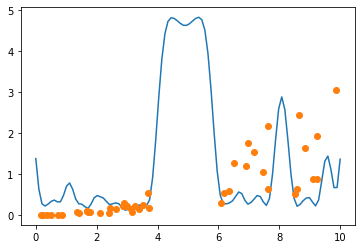

In [392]:
plt.plot(true_t, pred_var)
plt.plot(t, yerr**2, 'o')

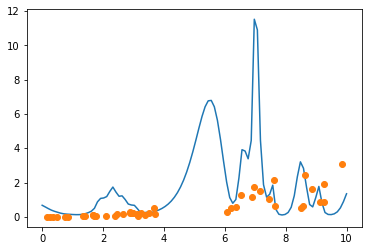

In [393]:
plt.plot(true_t, gp2_diag)
plt.plot(t, yerr**2, 'o')

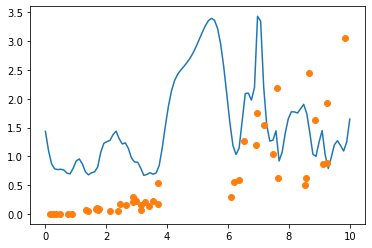

In [394]:
plt.plot(true_t, np.sqrt(pred_var+gp2_diag))
plt.plot(t, yerr**2, 'o')